# Math 584 - Homework 3
*Diane PERES*

---

## 1
In this exercise, you test the performance of a basic pairs trading strategy, using the back-testing method with the estimation window of size **N = 60 days**.
The cointegration constant **Cij** is determined according to the method by **Soren Jo- hansen**, as described in Chapter 3. Note that Soren Johansen’s method may yield two spreads, corresponding to the real eigenvalues of **(Φ+1)⊤**, in the notation of Chapter 3. In such a case, we pick a spread with the smallest p-value of the DF test (among the spreads with positive cointegration constants).
A pair is considered **cointegrated** if the following three conditions are satisfied: 

(i) the cointegration constant is positive 


(ii) the p-value of the Dickey-Fuller test of order 2, applied to the associated spread, does not exceed **p∗ = 0.01** 


(iii) the sum of the two auto-regressive coefficients, estimated via the Yule-Walker method of order 2, does not exceed **ρ∗ = 0.7**.


For the **stop-loss condition**, use the maximum holding time of **T ̄ = 20 days** and **4σ ̃** as the maximum deviation of the spread from its mean, where σ ̃ is the standard deviation of the spread (computed when the pair is opened).
* A pair is **opened** if it is cointegrated and if the value of its spread is at least σ ̃ away from the mean μ of the spread. 
* A pair is **closed** whenever the stop-loss condition is triggered or whenever the spread of the pair crosses onto the opposite side of μ.

When opening a pair, determine the size of your investment in each of the two asso- ciated assets so that the maximum of the dollar amounts invested on the long and on the short sides of the pair (these amounts are considered in absolute value, without taking the signs into account) is equal to **$1, 000, 000**.

In [1]:
import pandas as pd
import numpy as np 
import csv
import matplotlib.pyplot as plt
import math
import yfinance as yf
from statsmodels.tsa import stattools
from statsmodels.tsa import arima_model
from statsmodels.graphics import gofplots
from statsmodels.regression import linear_model
import scipy.optimize
from scipy import stats
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')
# get warning for complex type

In [2]:
#read list of tickers from a csv file
tickers_file = 'TechTickers.csv'
tickers = []
f = open(tickers_file,"r",encoding='utf-8-sig')
for line in csv.reader(f):
    tickers.append(str(line[0]))
f.close
#print(tickers)
tickers_str = tickers[0]
for s in tickers[1:]: tickers_str=tickers_str+", "+s
#print(tickers_str)

start_date = "2021-01-01"
end_date = "2022-12-31"
stock_data = yf.download(tickers, start=start_date, end=end_date)

price = stock_data['Adj Close'].values
#days = price.shape[0]
ret = price[1:]/price[:-1]-1 # relative return

#mu = np.mean(ret,axis=0) * 250
#Sigma = np.cov(ret.T) * 250

[*********************100%***********************]  71 of 71 completed


In [3]:
# Zero risk return
p_star = 0.01 #maximum p-value of the Dickey-Fuller test of order 2, applied to the associated spread
phi_star = 0.7 #max value of the sum of the two auto-regressive coefficients, estimated via the Yule-Walker method of order 2
T = 20 #maximum holding time in days
N = 60 #estimation window of size N = 60 days
M = price.shape[0] #total numbers of days
d = price.shape[1] #71 is the number of basic assets
invest = 10e6 #the maximum of the $ amounts invested on the long + on the short sides of the pair

In [4]:
def estimate_c(t0,t,price1,price2):

    # compute a two-dimensional TS of the incremnets of two prices
    dx = [np.diff(price1[t0:t-1])]
    dx.append(np.diff(price2[t0:t-1]))
    dx = np.array(dx).T
    #print(dx.shape)

    dy = [np.diff(price1[t0+1:t])]
    dy.append(np.diff(price2[t0+1:t]))
    dy = np.array(dy).T
    #print(dy.shape)

    #compute the cointegration constant via regression applied to the two-dimensional TS of price increments
    reg_results = LinearRegression().fit(dx,dy)
    #print(reg_results.coef_)
    Phi = reg_results.coef_+np.identity(2)
    #print(Phi)
    res = [dy[i,:] - dx[i,:]@reg_results.coef_.T for i in range(len(dy[:,0]))]

    # Eigenvalues and eigenvector 
    rho, v = np.linalg.eig(Phi.T)
    #print(rho)
    #print(f'rho 1 real {rho[1].imag==0}')
    #print(f'rho 0 real {rho[0].imag==0}')
    #print(v[:,1])
    if rho[1].imag==0:
        c1 = -v[1,1]/v[0,1]
        Z1 = np.array(price1[t0:t])-np.array(price2[t0:t])*c1 # the spread 
        return(c1,Z1)
    elif rho[0].imag==0:
        c0 = -v[1,0]/v[0,0]
        Z0 = np.array(price1[t0:t])-np.array(price2[t0:t])*c0 # the spread 
        return(c0,Z0)
    else:
        return([-1,-1])
    

In [59]:
# Main Loop 
def back_test(log=False):
    #Initialisation
    P, P_plus, P_minus, dP = [[0]*d]*M, [[0]*d]*M, [[0]*d]*M, [[0]*d]*M
    dPi, dPj = [0]*d, [0]*d
    PnL, PnL_plus, PnL_minus, dPnL = [0], [0], [0], 0
    LC, SC = [], [] #Long and Short Capital

    Pair = [[0]*d]*d #Closed at the begining 
    hold = [[0]*d]*d #nbr of days we hold a pair
    close1, close2 = 0, 0 #nbr of pair closed due to the stop-loss and due to reaching a desired target
    opened = 0 
    
    mu_list, sigma_list, c_list = [[0]*d]*d, [[0]*d]*d, [[0]*d]*d

    # Back-test over t
    for t in range(N,M):
        #dPi, dPj = 0, 0 # old one 
        PnL.append(PnL[-1]), PnL_plus.append(PnL_plus[-1]), PnL_minus.append(PnL_minus[-1])
        lc, sc = 0, 0 # temporary Long and Short Capital

        #Over pairs:
        for i in range(0,d):
            #print(f'i={i}')

            for j in range(i+1,d):
                #print(f'j={j}')
                dPi, dPj = 0, 0

                if log==False:
                    price1 = stock_data['Adj Close'][tickers[i]].values
                    price2 = stock_data['Adj Close'][tickers[j]].values
                elif log==True:
                    price1 = np.log(stock_data['Adj Close'][tickers[i]].values)
                    price2 = np.log(stock_data['Adj Close'][tickers[j]].values)
                    
                # if the pair is CLOSE
                if Pair[i][j] == 0:

                    # (i) Estimate Cij
                    c, z = estimate_c(t-N,t,price1,price2)
                    mu = np.mean(z)
                    sigma = np.cov(z)
                    if c > 0:

                        # (ii) Unit root test for Z-mu with augmented DF (Checking stationnarity)
                        z_center = z-np.mean(z) # centered spread
                        my_DF = stattools.adfuller(z_center,1,'c',None) #run Dickey-Fuller test
                        #print(my_DF[0]) #test statistic value
                        p = my_DF[1] #pvalue
                        #print(my_DF[2]) #order of AR tested
                        if p < p_star:

                            # (iii) Fit ARP(p) to Z-mu
                            phi, sigma = linear_model.yule_walker(z_center,order=2)
                            #print(phi)
                            #print(sigma)
                            if phi[0]+phi[1] < phi_star:

                                print(f'({i},{j}) Cointegrated at t={t}, c={c}, z-mu(t)={z_center[-1]}')

                                if z_center[-1] < -c*sigma: # OPEN LONG position on Z
                                    print(f'({i},{j}) Opened at t={t}')
                                    opened+=1
                                    hold[i][j]=t
                                    
                                    dPi+= min(invest/price1[t],invest/(price2[t]*c))
                                    dPj+= - c * dPi

                                    Pair[i][j] = -1
                                    
                                    # Storing information
                                    mu_list[i][j], sigma_list[i][j], c_list[i][j],  = mu, sigma, c, 
                                    dP[t][i] += dPi
                                    dP[t][j] += dPj
                                    
                                elif z_center[-1] > c*sigma: # OPEN SHORT position on Z
                                    print(f'({i},{j}) Opened at t={t}')
                                    opened+=1
                                    hold[i][j]=t
                                    
                                    dPi+= - min(invest/price1[t],invest/(price2[t]*c))
                                    dPj+= c * dPi

                                    Pair[i][j] = 1

                                    # Storing information
                                    mu_list[i][j], sigma_list[i][j], c_list[i][j],  = mu, sigma, c, 
                                    dP[t][i] += dPi
                                    dP[t][j] += dPj

                # if the pair is OPEN
                if abs(Pair[i][j]) == 1:

                    #while a position in the pair is open, we dont change its characteristics
                    mu, sigma, c = mu_list[i][j], sigma_list[i][j], c_list[i][j]
                    z = np.array(price1[t-N:t])-np.array(price2[t-N:t])*c
                    z_center = z-mu

                    # If either satisfy we CLOSE the pair
                    pair_value = int(Pair[i][j])

                    # (i) check if Z has reach out the target, cross mu value
                    if (pair_value==1 and z[-1] < mu) or (pair_value==-1 and z[-1] > mu):
                        dP[t][i] = - dP[t][i]
                        dP[t][j] = - dP[t][j]
                        Pair[i][j] = 0
                        print(f'({i},{j}) Closed at t={t}')
                        close2+=1
                        hold[i][j] = t-hold[i][j]

                    # (ii) Stop-loss condition
                    #Use the max holding time of T = 20 days & 4σ as the max deviation of the spread from its mean
                    #elif (np.abs(z[-1] - z[-1]*c - mu)<= sigma*4):
                    elif (pair_value==1 and z_center[-1] > 4*sigma) or (pair_value==-1 and z_center[-1] < -4*sigma) or(t-hold[i][j] > T):
                        dP[t][i] = - dP[t][i]
                        dP[t][j] = - dP[t][j]
                        Pair[i][j] = 0
                        print(f'({i},{j}) Closed at t={t}')
                        close1+=1
                        hold[i][j] = t-hold[i][j]

        for i in range(1,d):
                price = stock_data['Adj Close'][tickers[i]].values


                P[t][i] =  P[t-1][i] + dP[t][i]
                P_plus[t][i] = max(P[t][i],0) 
                P_minus[t][i] = min(P[t][i],0) 

                PnL[-1]+= P[t][i]*(price[t] - price[t-1])
                PnL_plus[-1]+= P_plus[t][i]*(price[t] - price[t-1])
                PnL_minus[-1]+= P_minus[t][i]*(price[t] - price[t-1])

                lc += P_plus[t][i] * price[t]
                sc += P_minus[t][i] * price[t]

                #print(PnL[-1])
                dPnL += (1/(M-N)) * (PnL[-1]-PnL[-2])
        LC.append(lc)
        SC.append(sc)
        
    print('End of back-test')
    return(P, P_plus, P_minus, dP, PnL, PnL_plus, PnL_minus, dPnL, LC, SC, close1, close2, opened, hold)

## a)
* **Back-test** the basic pairs trading strategy for the cointegrated prices using your sample.
* Compute and plot the **PnL** of the strategy, along with the two PnLs coming from its **long** and **short** positions. Produce the plots of the **total capital** invested in the **long** and in the **short** positions of the strategy. Print the **mean, standard deviation**, and the **Sharpe ratio**, of the absolute returns of the PnL.
* Hedging with the **SP500** index, produce a plot of the **PnL** of the market-neutral version of this strategy. Print the **mean, standard deviation**, and the **Sharpe ratio**, of the absolute returns of the PnL.
* Compute how many **opened pairs were closed** due to the stop-loss and due to reaching a desired target. Produce two **histograms of the holding times**: for the pairs that were closed due to the stop-loss and for those closed due to reaching the target.


In [60]:
P, P_plus, P_minus, dP, PnL, PnL_plus, PnL_minus, dPnL, LC, SC, close1, close2, opened, holding_time = back_test()

(2,41) Cointegrated at t=60, c=2.20351369715924, z-mu(t)=-4.688257432732598
(2,49) Cointegrated at t=60, c=1.9814449417403788, z-mu(t)=-1.7197713968146786
(18,30) Cointegrated at t=60, c=7.935244018478261, z-mu(t)=7.5193818364824665
(30,61) Cointegrated at t=60, c=0.04746604117171992, z-mu(t)=-2.1258253705852326
(30,61) Opened at t=60
(31,61) Closed at t=60
(40,41) Cointegrated at t=60, c=0.5983175204849575, z-mu(t)=-0.5692361712205241
(0,6) Cointegrated at t=61, c=2.108404097173724, z-mu(t)=1.8336230566399365
(40,41) Cointegrated at t=61, c=0.7124561838234288, z-mu(t)=-2.4543705223042025
(40,41) Opened at t=61
(0,41) Closed at t=62
(40,41) Cointegrated at t=62, c=0.7803296841795231, z-mu(t)=-4.124904028563407
(40,41) Opened at t=62
(51,62) Cointegrated at t=62, c=0.8365413582728874, z-mu(t)=-17.61831657575496
(51,62) Opened at t=62
(52,62) Closed at t=62
(57,62) Cointegrated at t=62, c=0.6542677689843088, z-mu(t)=-13.943335386541833
(57,62) Opened at t=62
(58,62) Closed at t=62
(0,41)

### Total Capital

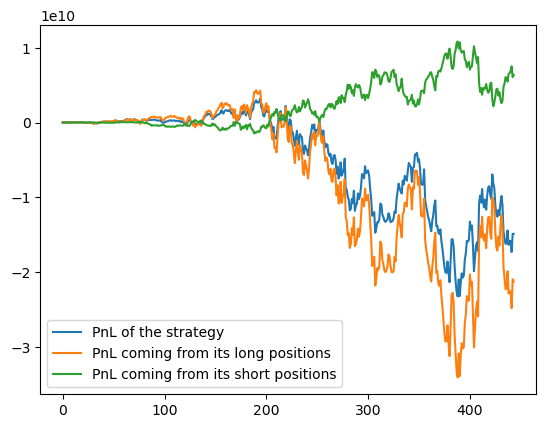

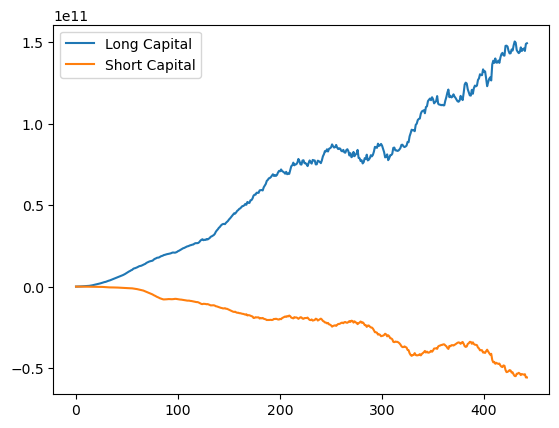

The mean of the absolute returns of the PnL is: -8391544490.435919
The standard deviaiton of the absolute returns of the PnL is: 15724358456.551744
The sharp ratio of the absolute returns of the PnL is: -0.5336653011073708


In [7]:
# PnL
#print(PnL)
plt.plot(PnL, label='PnL of the strategy')
plt.plot(PnL_plus, label='PnL coming from its long positions')
plt.plot(PnL_minus, label='PnL coming from its short positions')
plt.legend()
plt.show()

#print(LC)
plt.plot(LC, label='Long Capital')
#print(SC)
plt.plot(SC, label='Short Capital')
plt.legend()
plt.show()

# Mean of the absolute returns of the PnL
mean = np.mean(np.diff (PnL)) *250
# Standard deviation of the absolute returns of the PnL
std = np.std(np.diff (PnL)) *np. sqrt (250)
# Sharp ratio of the absolute returns of the PnL
Sharpe = mean/std

print(f'The mean of the absolute returns of the PnL is: {mean}')
print(f'The standard deviaiton of the absolute returns of the PnL is: {std}')
print(f'The sharp ratio of the absolute returns of the PnL is: {Sharpe}')


### Market Neutral

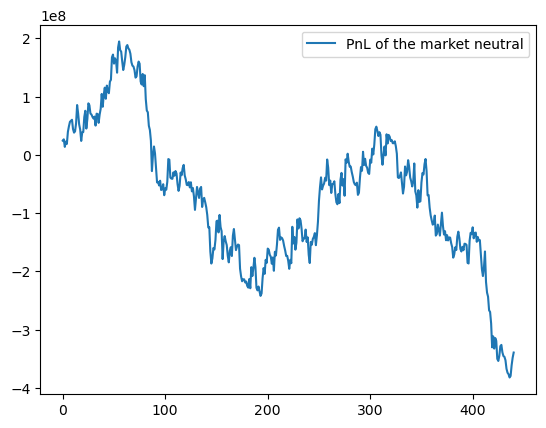

The mean of the absolute returns of the PnL is: -200698915.00132075
The standard deviaiton of the absolute returns of the PnL is: 278213180.27865684
The sharp ratio of the absolute returns of the PnL is: -0.7213853592425125


In [44]:
PnL_hedge = []
pnl = 0
capital = [y - x for x, y in zip(SC, LC)]
sum_ret = [ret[t] + ret[-t] for t in range(M-1)]

for t in range(M-N-1):
    returns = np.array(P[t] + [capital[-t]])[:-1].T @ np.array(sum_ret[t])
    #returns = (P[t] @ ret[t+1]) + capital[-t]*ret[-t-1])
    pnl += returns
    PnL_hedge.append(pnl)

# PnL
plt.plot(PnL_hedge[1:], label='PnL of the market neutral')
plt.legend()
plt.show()

# Mean of the absolute returns of the PnL
mean_hedge = np.mean(np.diff (PnL_hedge)) *250
# Standard deviation of the absolute returns of the PnL
std_hedge = np.std(np.diff (PnL_hedge)) *np. sqrt (250)
# Sharp ratio of the absolute returns of the PnL
Sharpe_hedge = mean_hedge/std_hedge

print(f'The mean of the absolute returns of the PnL is: {mean_hedge}')
print(f'The standard deviaiton of the absolute returns of the PnL is: {std_hedge}')
print(f'The sharp ratio of the absolute returns of the PnL is: {Sharpe_hedge}')


### Pair closed

Over 1004 opened pairs, 1004 have been closed.
471 pairs were closed due to the stop-loss and 533 pairs were closed due to reaching the desired target.


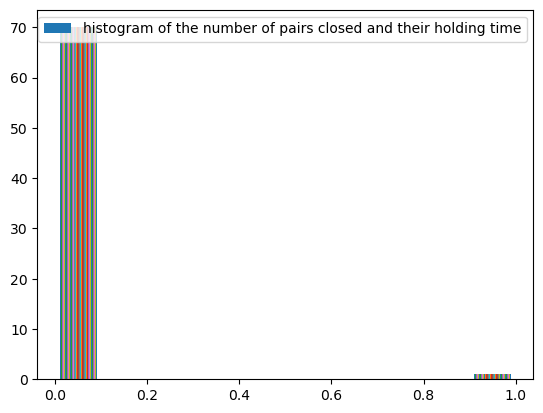

In [63]:
print(f'Over {opened} opened pairs, {close1+close2} have been closed.')
print(f'{close1} pairs were closed due to the stop-loss and {close2} pairs were closed due to reaching the desired target.')

plt.hist(holding_time, label = 'histogram of the number of pairs closed and their holding time')
plt.legend()
plt.show()


## b) Transaction Cost

In [47]:
# compute alpha star
data_cali = ret[0:N]
capital = [x + y for x, y in zip(SC, LC)]
Mu = np.array([1,np.mean(data_cali)]) 
sig = np.std(data_cali)

obj4 = lambda alpha : (1+alpha@(Mu+np.array([0,sig])) + 1+alpha@(Mu-np.array([0,sig])))
alpha0 = np.array([0.5,0.5])
constr = {'type': 'eq', 'fun': lambda alpha:  np.sum(alpha) - 1}
opt = scipy.optimize.minimize(obj4, alpha0, tol=1e-20, constraints=constr,  options={'maxiter':1e6})
alpha = float(opt.x[1])
#print(opt.x)

# Compute PnL and PnL with hedge
sum_ret = [ret[t] + ret[-t] for t in range(M-1)]
tcost, pnl_cost_hedge, lc, sc = 0.001, 0, 0, 0
PnL_cost, PnL_cost_plus, PnL_cost_minus, dPnL_cost, LC_cost, SC_cost, PnL_cost_hedge = [], [], [], 0, [], [], []
for t in range(M-N-1):
    Tcost = tcost* abs((alpha - alpha*float( 1+ P[t] @ ret[t+1]))/(1+(1-alpha)*capital[t] + alpha*float(P[t] @ ret[t+1])))
    
    PnL_cost.append(0),PnL_cost_plus.append(0),PnL_cost_minus.append(0)
    for i in range(d):
        PnL_cost[t]+= P[t][i]*(price[t] - price[t-1]-Tcost)
        PnL_cost_plus[-1]+= P_plus[t][i]*(price[t] - price[t-1]-Tcost)
        PnL_cost_minus[-1]+= P_minus[t][i]*(price[t] - price[t-1]-Tcost)

    lc += P_plus[t][-1] * (price[t]-Tcost)
    sc += P_minus[t][-1] * (price[t]-Tcost)

    #print(PnL[-1])
    dPnL_cost += (1/(M-N)) * (PnL_cost[t]-PnL_cost[t-1])
    LC_cost.append(lc)
    SC_cost.append(sc)

    # Hedging
    sum_ret = [ret[t] + ret[-t] - Tcost for t in range(M-1)]
    returns = np.array(P[t] + [lc - sc])[:-1].T @ np.array(sum_ret[t])
    pnl_cost_hedge += returns
    PnL_cost_hedge.append(pnl_cost_hedge)


### Total Capital with cost

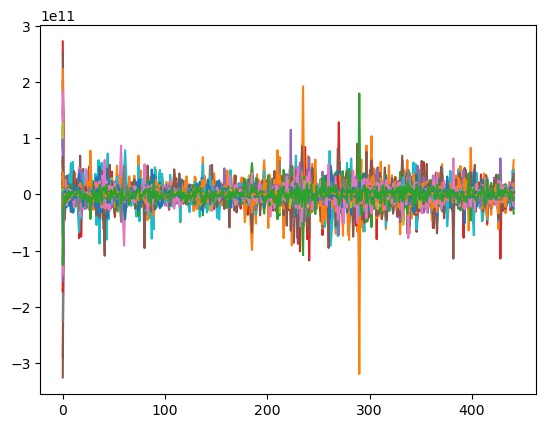

The mean of the absolute returns of the PnL is: 60546049.536431305
The standard deviaiton of the absolute returns of the PnL is: 106488060095.68274
The sharp ratio of the absolute returns of the PnL is: 0.0005685712509179795


In [49]:
# PnL
#print(PnL)
plt.plot(PnL_cost, label='PnL of the strategy with cost')
plt.plot(PnL_cost_plus, label='PnL coming from its long positions with cost')
plt.plot(PnL_cost_minus, label='PnL coming from its short positions with cost')
#plt.legend()
plt.show()

# Mean of the absolute returns of the PnL
mean_cost = np.mean(np.diff (PnL_cost)) *250
# Standard deviation of the absolute returns of the PnL
std_cost = np.std(np.diff (PnL_cost)) *np. sqrt (250)
# Sharp ratio of the absolute returns of the PnL
Sharpe_cost = mean_cost/std_cost

print(f'The mean of the absolute returns of the PnL is: {mean_cost}')
print(f'The standard deviaiton of the absolute returns of the PnL is: {std_cost}')
print(f'The sharp ratio of the absolute returns of the PnL is: {Sharpe_cost}')

### Market Neutral

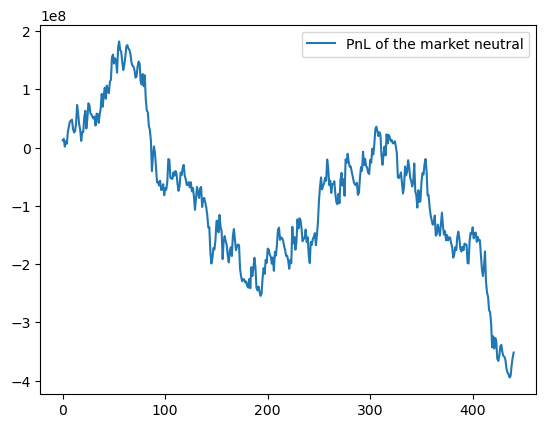

The mean of the absolute returns of the PnL is: -200698915.00132075
The standard deviaiton of the absolute returns of the PnL is: 278213180.27865684
The sharp ratio of the absolute returns of the PnL is: -0.7213853592425125


In [50]:
# PnL
plt.plot(PnL_cost_hedge[1:], label='PnL of the market neutral')
plt.legend()
plt.show()

# Mean of the absolute returns of the PnL
mean_hedge = np.mean(np.diff (PnL_hedge)) *250
# Standard deviation of the absolute returns of the PnL
std_hedge = np.std(np.diff (PnL_hedge)) *np. sqrt (250)
# Sharp ratio of the absolute returns of the PnL
Sharpe_hedge = mean_hedge/std_hedge

print(f'The mean of the absolute returns of the PnL is: {mean_hedge}')
print(f'The standard deviaiton of the absolute returns of the PnL is: {std_hedge}')
print(f'The sharp ratio of the absolute returns of the PnL is: {Sharpe_hedge}')


## c) Log-price

In [64]:
P, P_plus, P_minus, dP, PnL, PnL_plus, PnL_minus, dPnL, LC, SC, close1, close2, opened, holding_time = back_test(log=True)

(2,41) Cointegrated at t=60, c=3.554862508736211, z-mu(t)=-0.04155130683879449
(2,49) Cointegrated at t=60, c=2.10817499482134, z-mu(t)=-0.01935908945447906
(18,30) Cointegrated at t=60, c=13.049120511577748, z-mu(t)=0.09392572712715008
(40,41) Cointegrated at t=60, c=3.115195730874798, z-mu(t)=-0.014144983412933243
(0,6) Cointegrated at t=61, c=2.0091051477924857, z-mu(t)=0.01467295375047506
(40,41) Cointegrated at t=61, c=3.6487671194471267, z-mu(t)=-0.06292887326792673
(0,6) Cointegrated at t=62, c=2.070080134046701, z-mu(t)=-0.025929684017704346
(40,41) Cointegrated at t=62, c=3.939730506789967, z-mu(t)=-0.10360263576749063
(51,62) Cointegrated at t=62, c=2.690809185948135, z-mu(t)=-0.14020011664501375
(51,62) Opened at t=62
(52,62) Closed at t=62
(57,62) Cointegrated at t=62, c=3.7456351109278505, z-mu(t)=-0.19502261173671798
(25,55) Cointegrated at t=63, c=1.1708764158522433, z-mu(t)=-0.015135878141259607
(31,69) Cointegrated at t=63, c=2.331088065024118, z-mu(t)=-0.0212999844153

### Total Capital

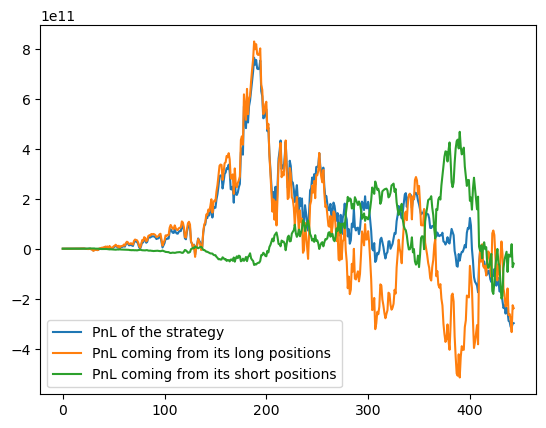

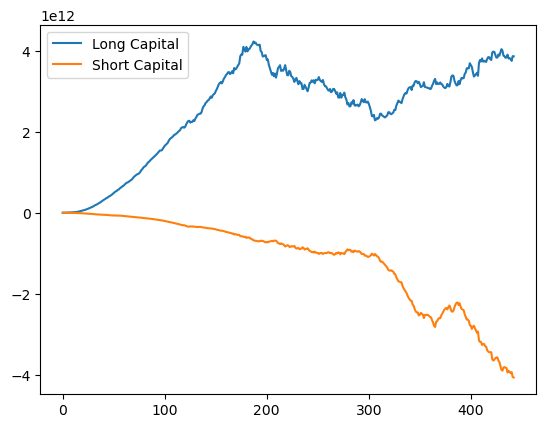

The mean of the absolute returns of the PnL is: -168401222209.938
The standard deviaiton of the absolute returns of the PnL is: 567419624477.2603
The sharp ratio of the absolute returns of the PnL is: -0.2967842755968811


In [76]:
# PnL
#print(PnL)
plt.plot(PnL, label='PnL of the strategy')
plt.plot(PnL_plus, label='PnL coming from its long positions')
plt.plot(PnL_minus, label='PnL coming from its short positions')
plt.legend()
plt.show()

#print(LC)
plt.plot(LC, label='Long Capital')
#print(SC)
plt.plot(SC, label='Short Capital')
plt.legend()
plt.show()

# Mean of the absolute returns of the PnL
mean = np.mean(np.diff (PnL)) *250
# Standard deviation of the absolute returns of the PnL
std = np.std(np.diff (PnL)) *np. sqrt (250)
# Sharp ratio of the absolute returns of the PnL
Sharpe = mean/std

print(f'The mean of the absolute returns of the PnL is: {mean}')
print(f'The standard deviaiton of the absolute returns of the PnL is: {std}')
print(f'The sharp ratio of the absolute returns of the PnL is: {Sharpe}')


### Market Neutral

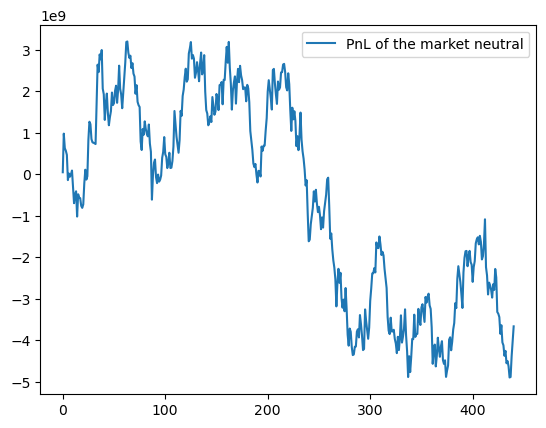

The mean of the absolute returns of the PnL is: -2070701061.6864762
The standard deviaiton of the absolute returns of the PnL is: 5783379651.377928
The sharp ratio of the absolute returns of the PnL is: -0.35804342555881113


In [53]:
PnL_hedge = []
pnl = 0
capital = [x + y for x, y in zip(SC, LC)]
sum_ret = [ret[t] + ret[-t] for t in range(M-1)]

for t in range(M-N-1):
    returns = np.array(P[t] + [capital[-t]])[:-1].T @ np.array(sum_ret[t])
    #returns = (P[t] @ ret[t+1]) + capital[-t]*ret[-t-1])
    pnl += returns
    PnL_hedge.append(pnl)

# PnL
plt.plot(PnL_hedge[1:], label='PnL of the market neutral')
plt.legend()
plt.show()

# Mean of the absolute returns of the PnL
mean_hedge = np.mean(np.diff (PnL_hedge)) *250
# Standard deviation of the absolute returns of the PnL
std_hedge = np.std(np.diff (PnL_hedge)) *np. sqrt (250)
# Sharp ratio of the absolute returns of the PnL
Sharpe_hedge = mean_hedge/std_hedge

print(f'The mean of the absolute returns of the PnL is: {mean_hedge}')
print(f'The standard deviaiton of the absolute returns of the PnL is: {std_hedge}')
print(f'The sharp ratio of the absolute returns of the PnL is: {Sharpe_hedge}')


### Pair closed

Over 895 opened pairs, 895 have been closed.
442 pairs were closed due to the stop-loss and 453 pairs were closed due to reaching the desired target.


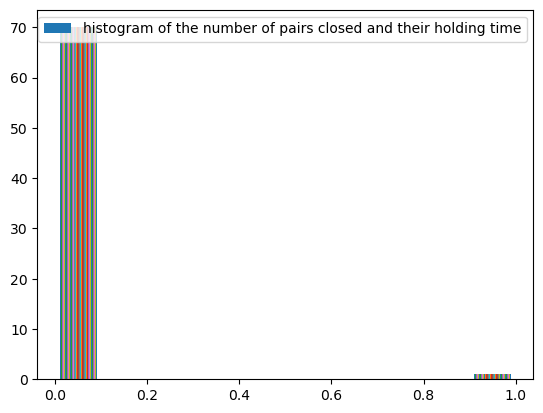

In [65]:
print(f'Over {opened} opened pairs, {close1+close2} have been closed.')
print(f'{close1} pairs were closed due to the stop-loss and {close2} pairs were closed due to reaching the desired target.')

plt.hist(holding_time, label = 'histogram of the number of pairs closed and their holding time')
plt.legend()
plt.show()
